In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

res = sc.read_h5ad('/lab/solexa_sun/lab_members/yancui/Haruka/lung_res_new_new.h5ad')

def calculate_slice_frequency_vectors(
    adata, 
    obs_name, 
    slice_column='slice_id'
):
    """
    Calculate frequency vectors for each slice_id.
    
    Parameters:
    -----------
    adata : anndata.AnnData
        Input annotated data matrix
    obs_name : str
        Name of the observation column to calculate frequencies for
    slice_column : str, optional (default='slice_id')
        Column containing slice identifiers
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with frequency vectors for each slice_id
    """
    # Group by slice_id and calculate frequency vectors
    freq_vectors = adata.obs.groupby(slice_column)[obs_name].apply(
        lambda x: x.value_counts(normalize=True)
    ).unstack(fill_value=0)

    obs = adata.obs.groupby(slice_column)[['sample_affect', 'sample_type', 'run']].first()
    
    return freq_vectors, obs

freq_vec, obs = calculate_slice_frequency_vectors(
     res, 
     obs_name='cluster_haruka_salient',
    slice_column='slice_id'
)


/tmp/ipykernel_1344131/2180748086.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_vectors = adata.obs.groupby(slice_column)[obs_name].apply(
/tmp/ipykernel_1344131/2180748086.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs = adata.obs.groupby(slice_column)[['sample_affect', 'sample_type', 'run']].first()


In [2]:
bulk_adata = sc.get.aggregate(res, by='slice_id', func=['mean'])

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


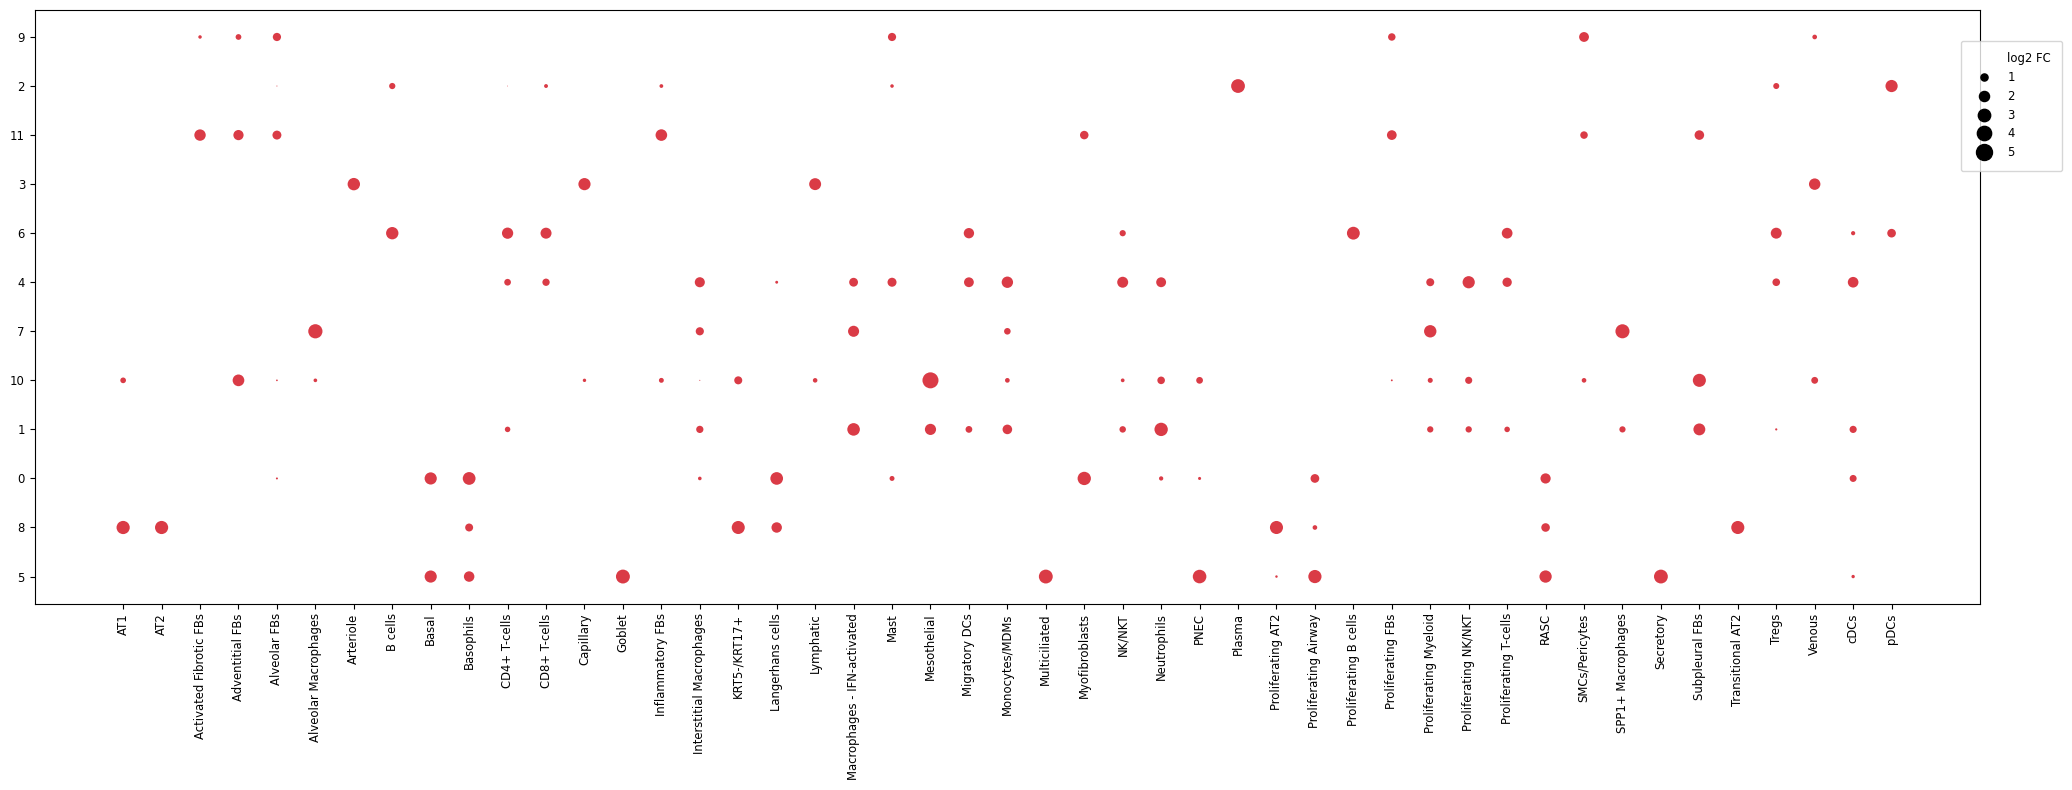

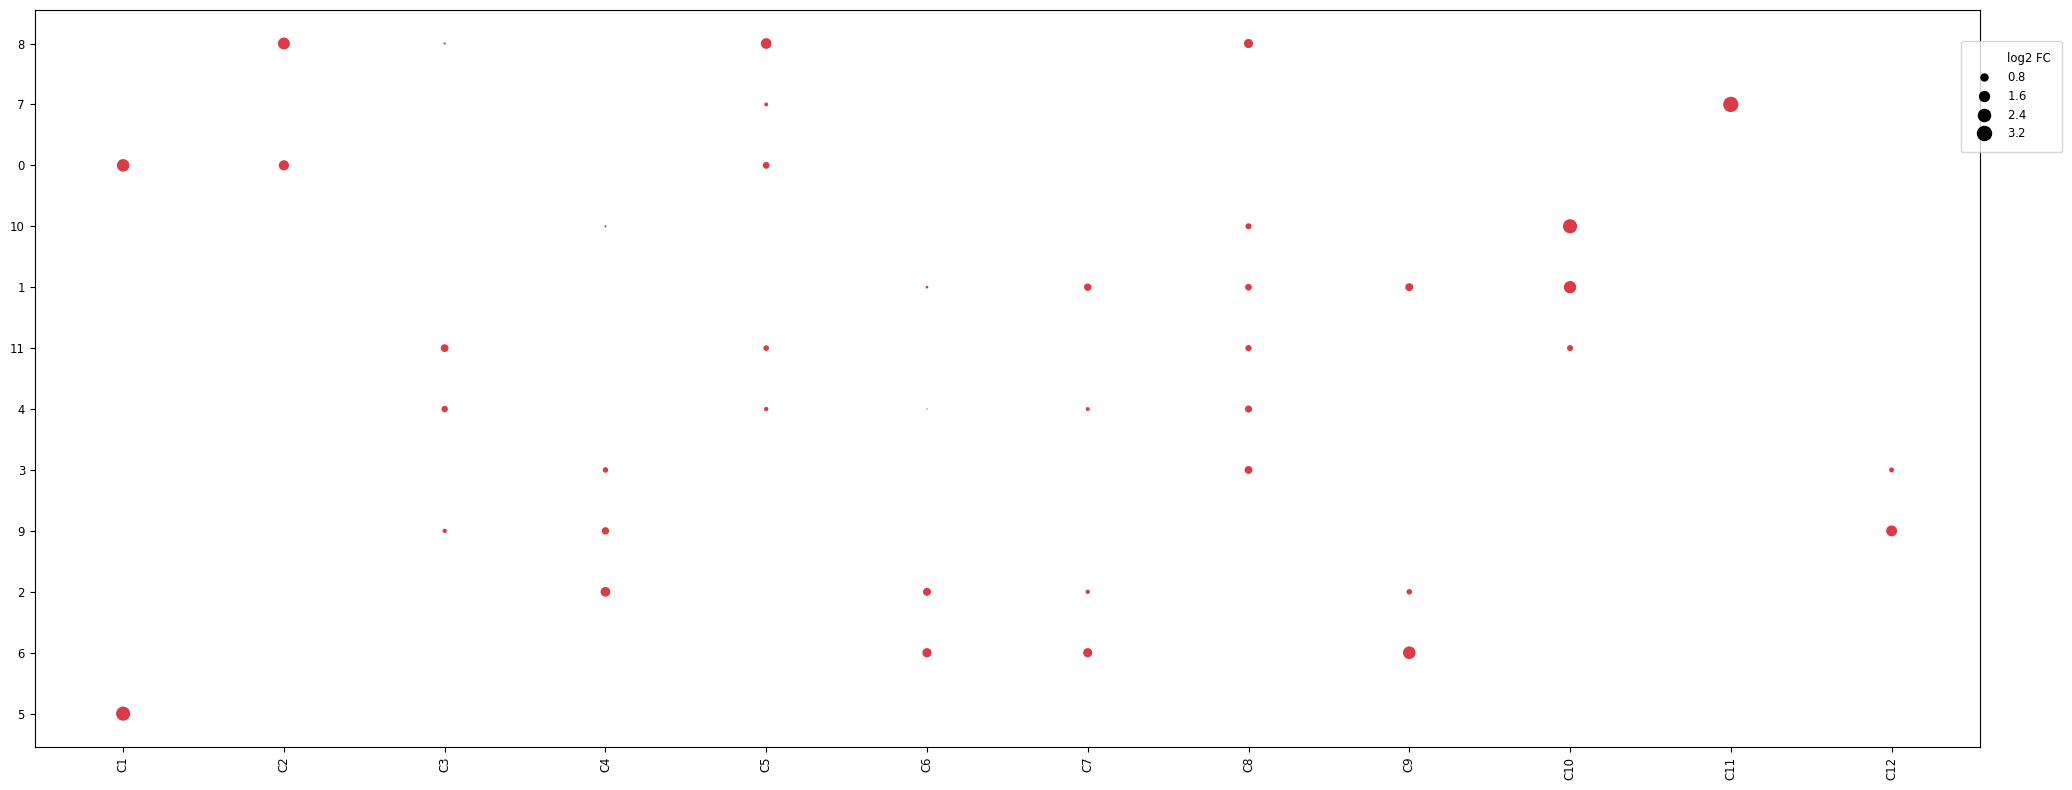

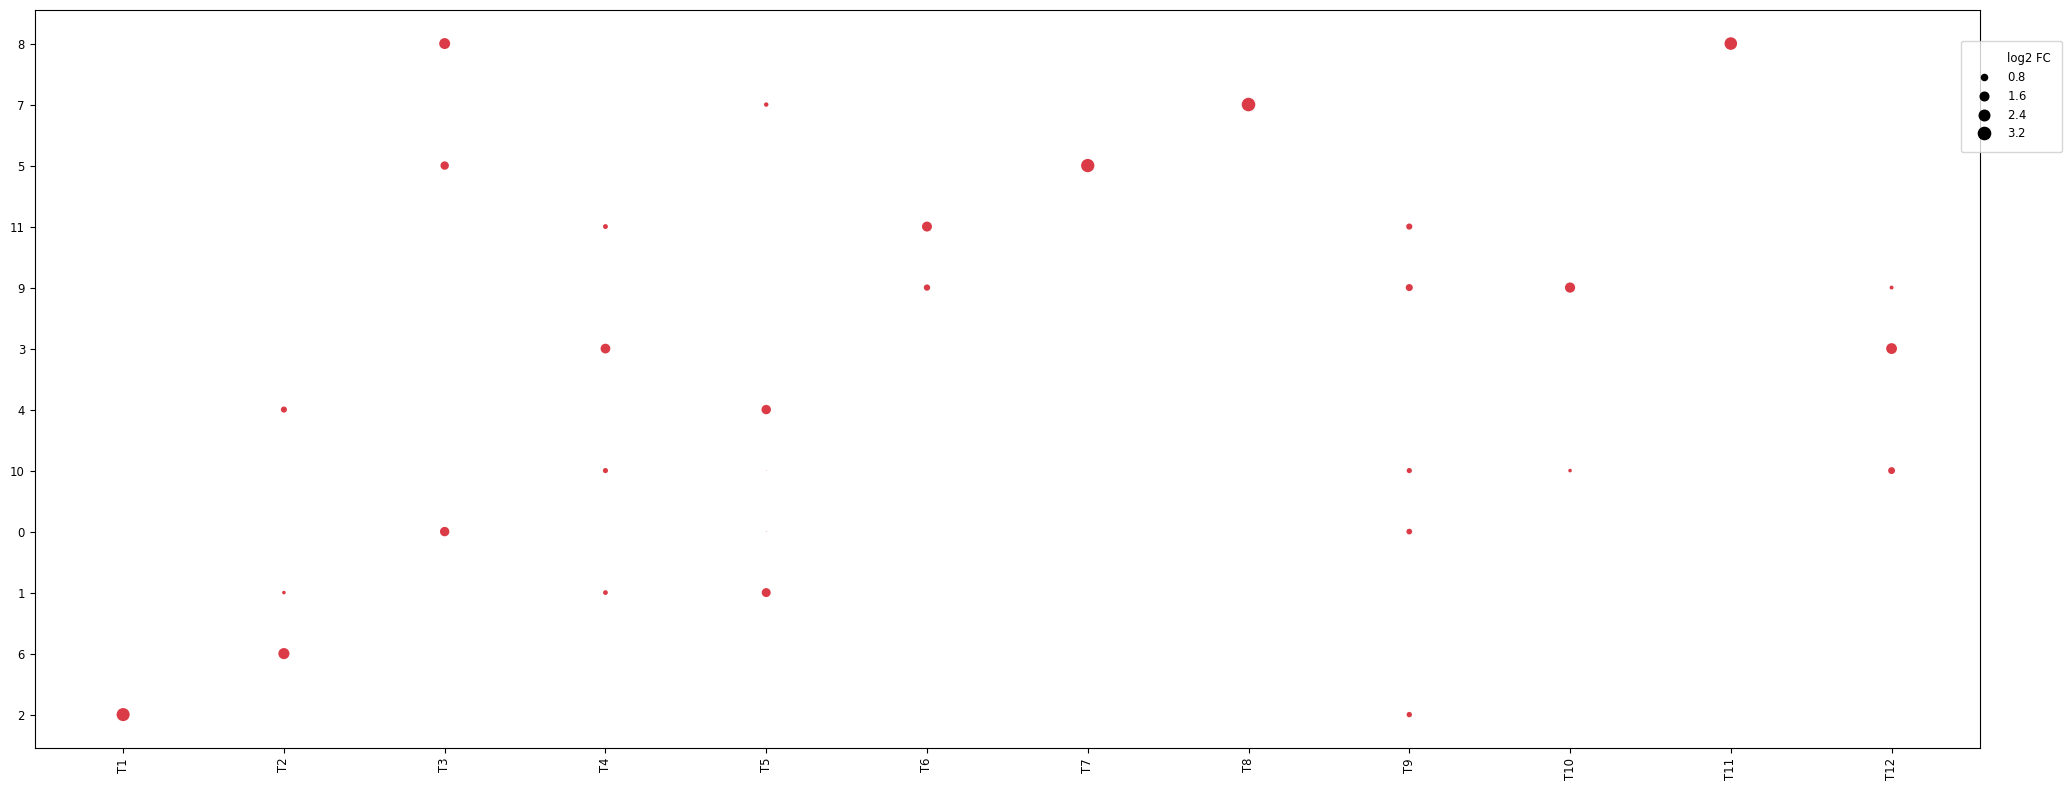

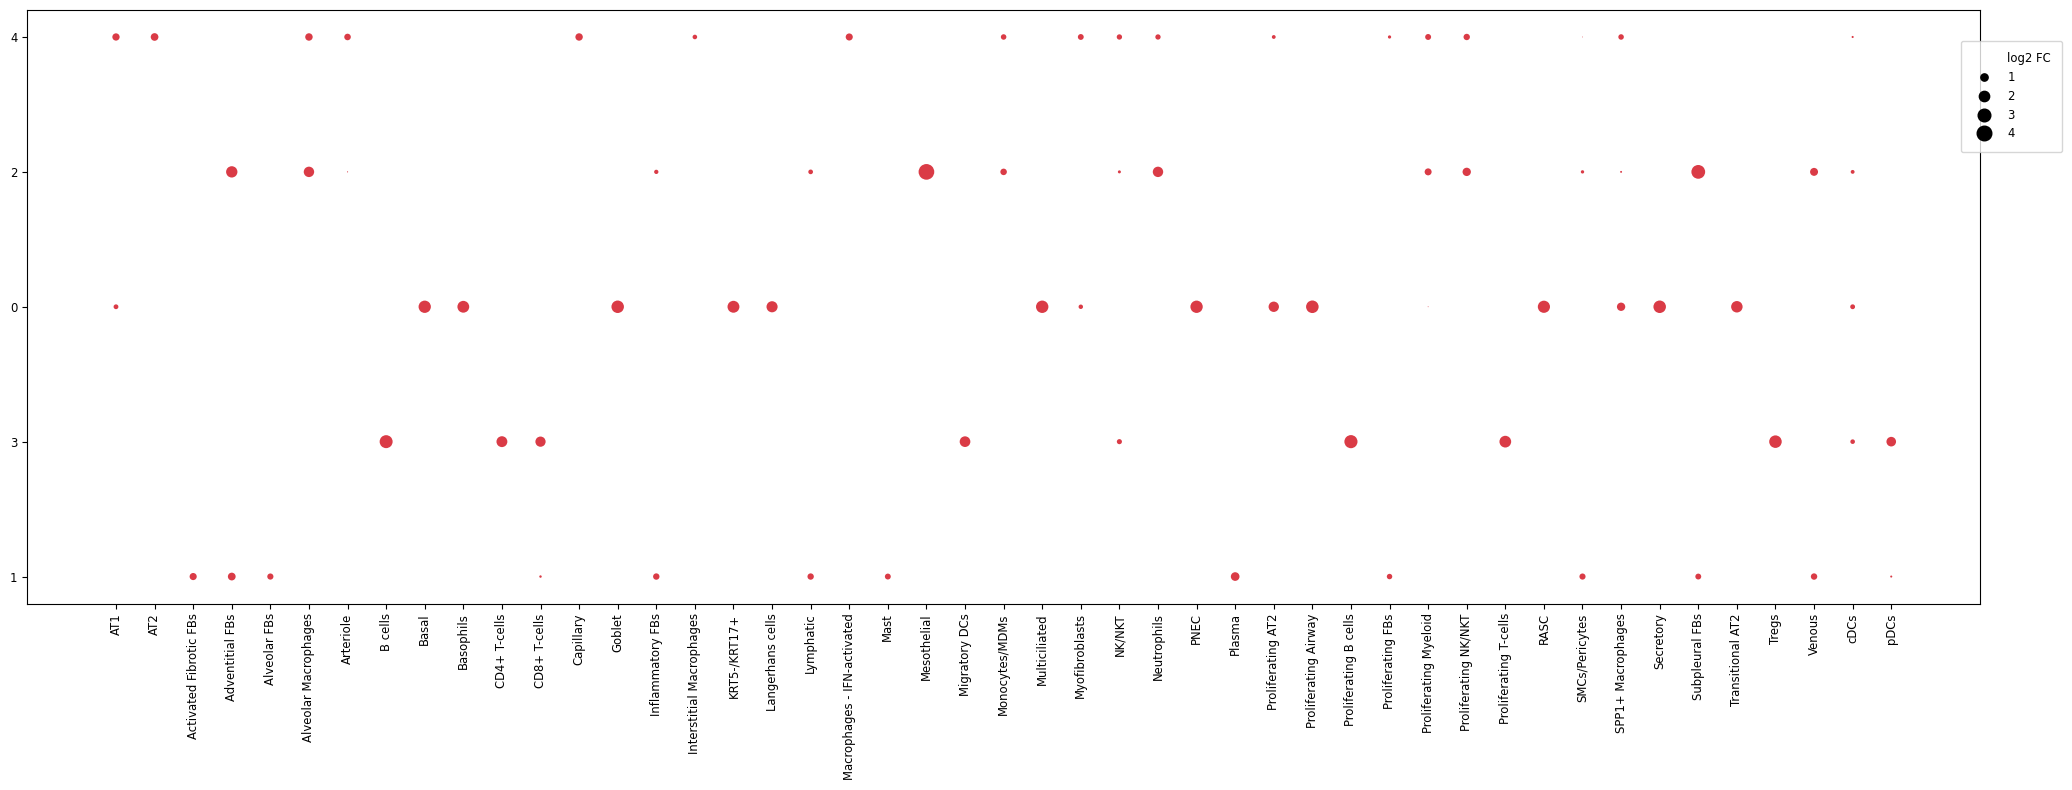

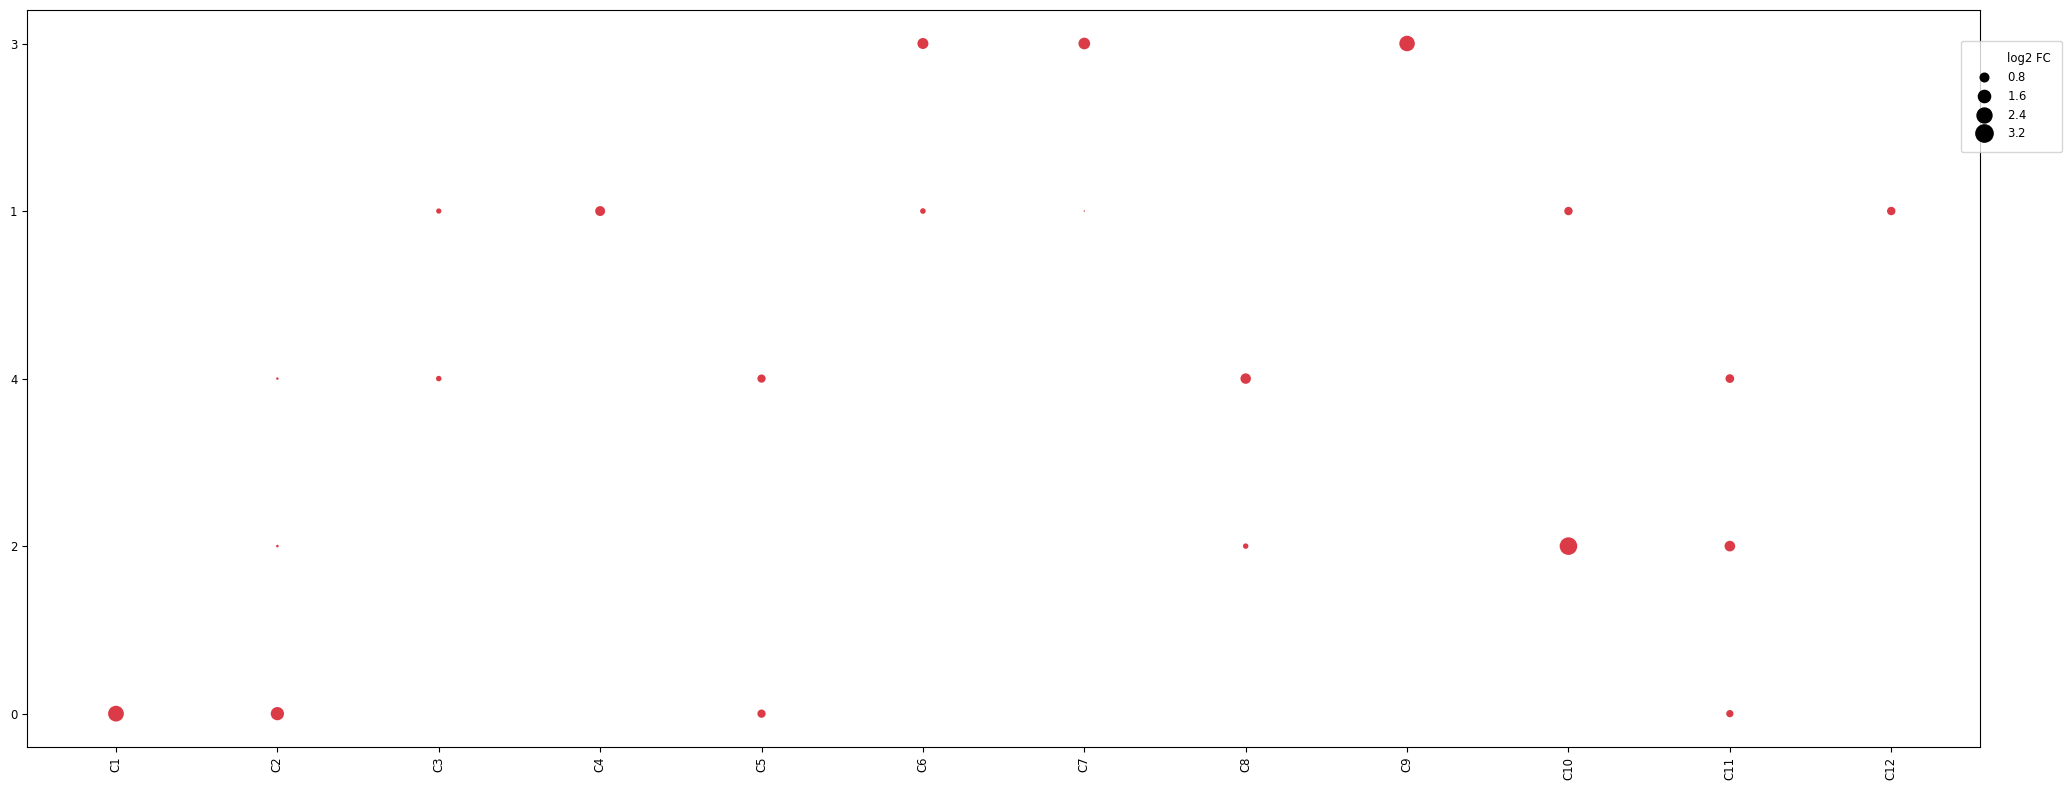

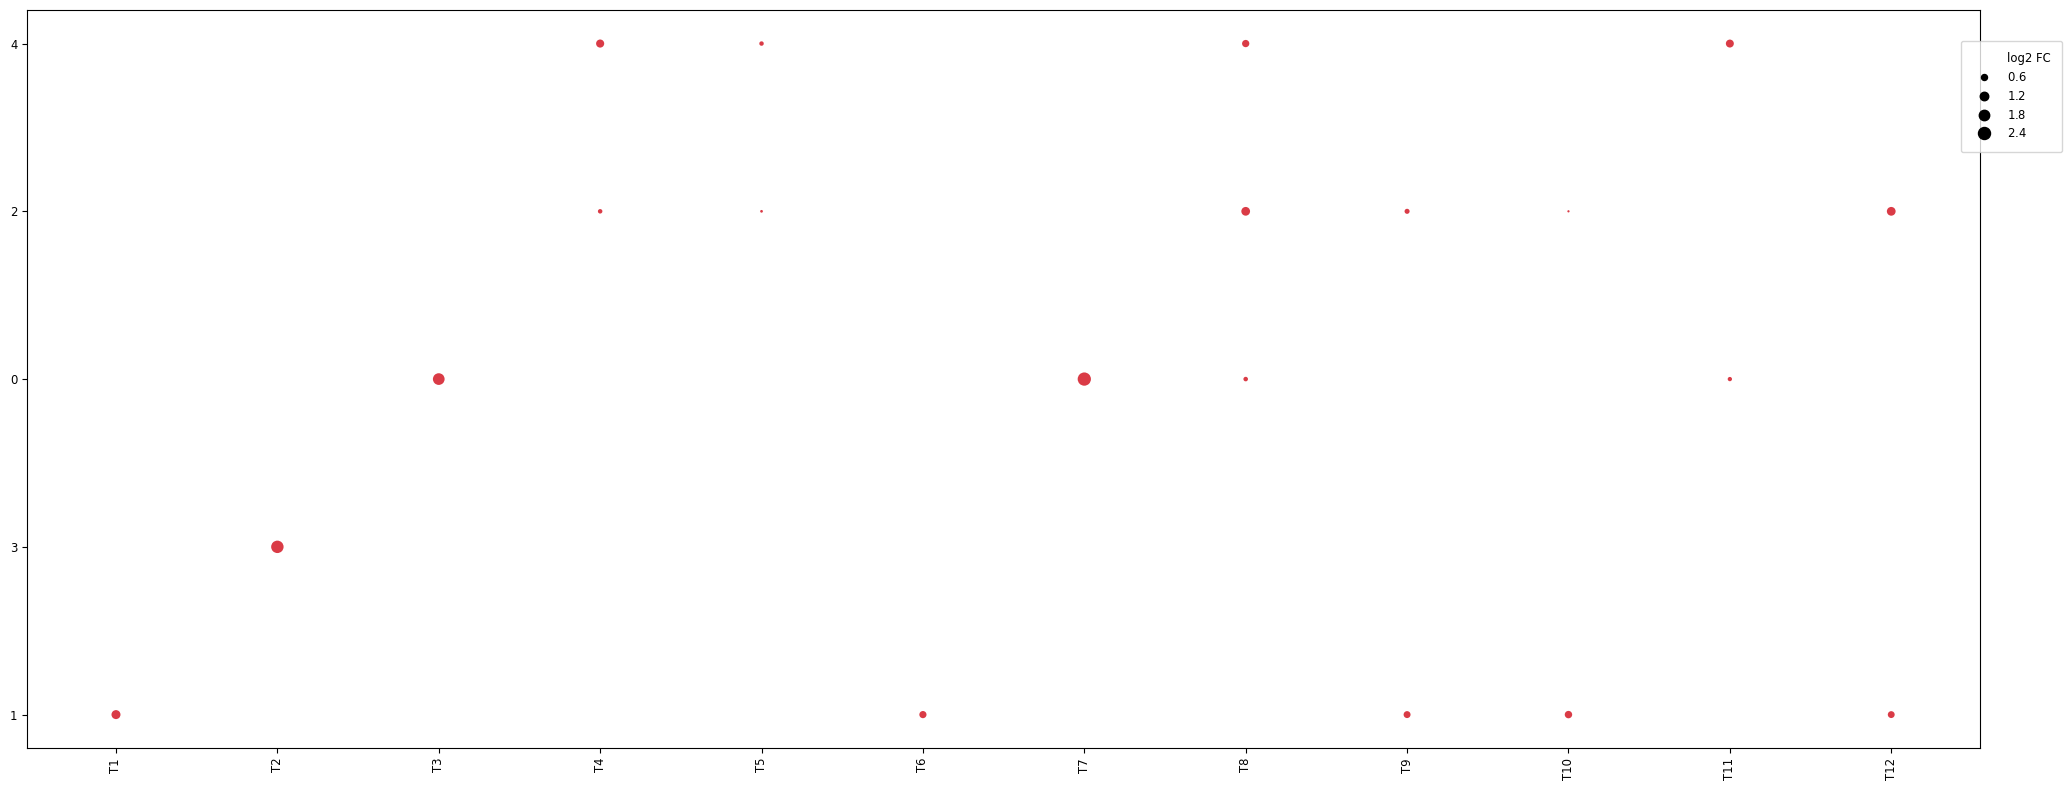

In [ ]:
import cellcharter as cc

for group in ['background', 'salient']:
    for label in ['final_CT', 'CNiche', 'TNiche']:

        cc.gr.enrichment(res, group_key=f'cluster_haruka_{group}', label_key=label)

        cc.pl.enrichment(res, group_key=f'cluster_haruka_{group}', label_key=label, figsize=(20, 8))


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['TILD028LA', 'TILD049MA', 'TILD080LA', 'TILD111LA', 'TILD113LA']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


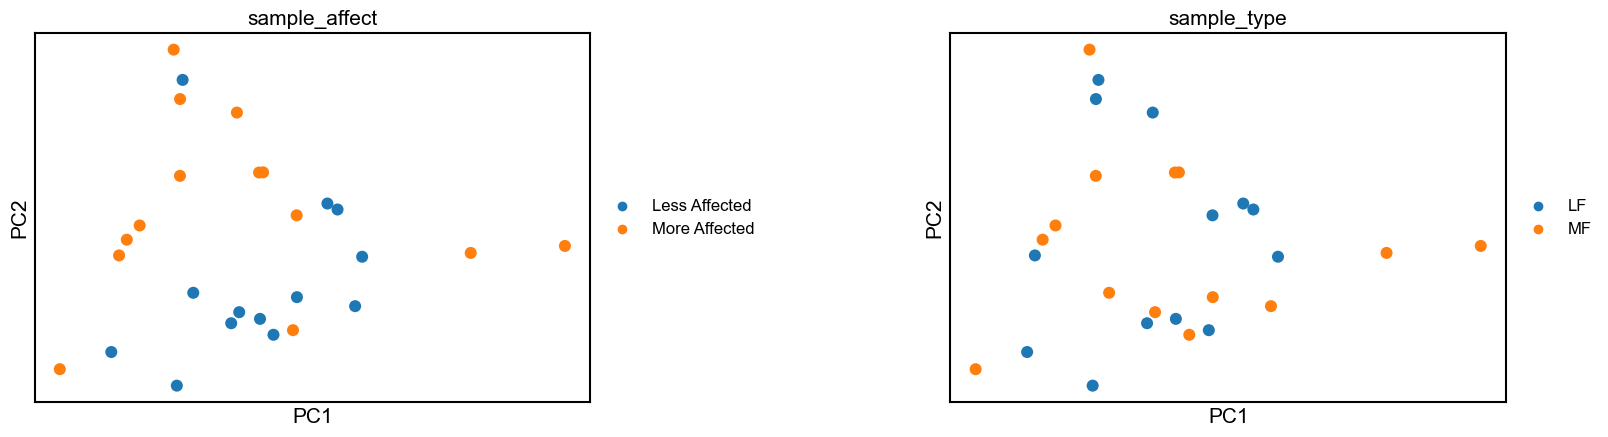

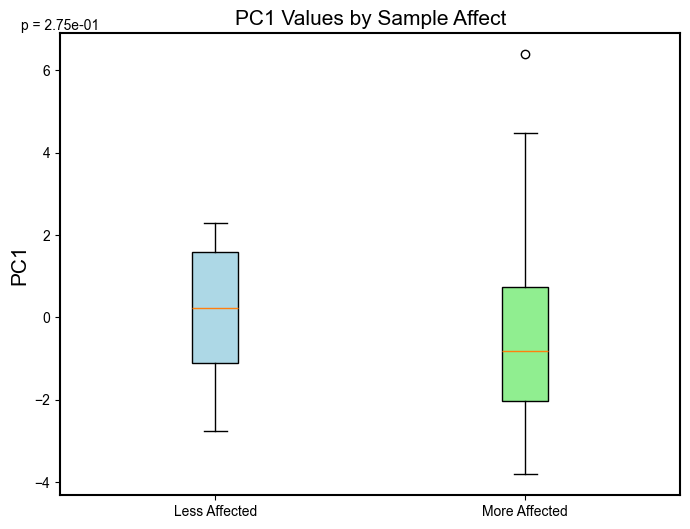

Less Affected Mean PC1: 0.180
More Affected Mean PC1: -0.168
Absolute difference in means: 0.348

Less Affected PC1 Std: 1.506
More Affected PC1 Std: 2.686

Effect size (Cohen's d): 0.160

PC1 explained variance ratio: 0.456


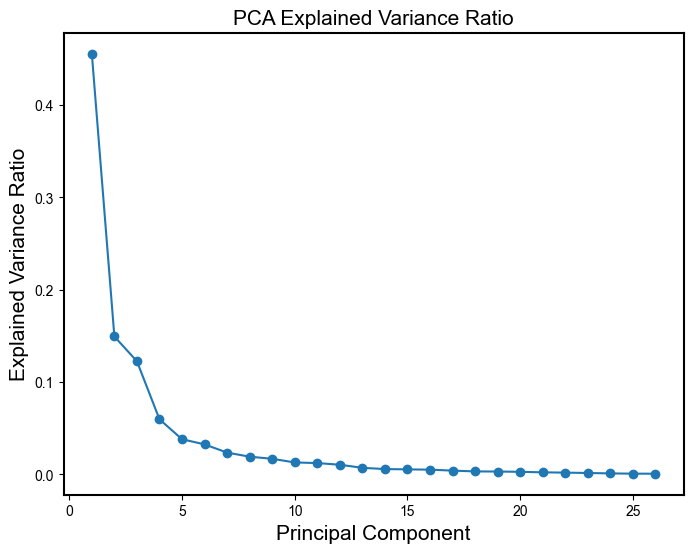

In [4]:
from matplotlib import pyplot as plt

import anndata as ad 

patient_adata = ad.AnnData(X=bulk_adata.layers['mean'], obs=obs)
import scanpy as sc 

patient_adata.obs = patient_adata.obs.astype('category')

plt.rcParams['pdf.fonttype'] = 42  
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 15  # Adjust title size
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 'large'

sc.pp.pca(patient_adata) 
sc.tl.pca(patient_adata)
sc.pl.pca(patient_adata, color=['sample_affect', 'sample_type'], s=300, wspace=0.5)

# Extract PC1 values and group by sample_affect
pc1_values = patient_adata.obsm['X_pca'][:, 0]
sample_affects = patient_adata.obs['sample_affect']

# Create figure
plt.figure(figsize=(8, 6))

# Create boxplot
box_plot = plt.boxplot([pc1_values[sample_affects == 'Less Affected'], 
                       pc1_values[sample_affects == 'More Affected']], 
                      labels=['Less Affected', 'More Affected'],
                      patch_artist=True)

# Customize boxplot colors
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Perform Mann-Whitney U test
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(pc1_values[sample_affects == 'Less Affected'],
                         pc1_values[sample_affects == 'More Affected'])

# Add p-value annotation
plt.text(0.5, plt.ylim()[1], f'p = {pval:.2e}', 
         horizontalalignment='center',
         verticalalignment='bottom')

# Customize plot
plt.ylabel('PC1')
plt.title('PC1 Values by Sample Affect')


plt.show()

plt.close()

plt.close()

less_affected_pc1 = pc1_values[sample_affects == 'Less Affected']
more_affected_pc1 = pc1_values[sample_affects == 'More Affected']

print(f"Less Affected Mean PC1: {less_affected_pc1.mean():.3f}")
print(f"More Affected Mean PC1: {more_affected_pc1.mean():.3f}")
print(f"Absolute difference in means: {abs(less_affected_pc1.mean() - more_affected_pc1.mean()):.3f}")

# Calculate standard deviations
print(f"\nLess Affected PC1 Std: {less_affected_pc1.std():.3f}")
print(f"More Affected PC1 Std: {more_affected_pc1.std():.3f}")

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt((less_affected_pc1.var() + more_affected_pc1.var()) / 2)
cohens_d = abs(less_affected_pc1.mean() - more_affected_pc1.mean()) / pooled_std
print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")

# Calculate explained variance ratio for PC1
explained_var_ratio = patient_adata.uns['pca']['variance_ratio'][0]
print(f"\nPC1 explained variance ratio: {explained_var_ratio:.3f}")

plt.figure(figsize=(8, 6))
explained_var_ratio = patient_adata.uns['pca']['variance_ratio']
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio') 
plt.title('PCA Explained Variance Ratio')
plt.grid(False)
plt.show()


/tmp/ipykernel_1344131/2180748086.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_vectors = adata.obs.groupby(slice_column)[obs_name].apply(
/tmp/ipykernel_1344131/2180748086.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs = adata.obs.groupby(slice_column)[['sample_affect', 'sample_type', 'run']].first()
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['TILD028LA', 'TILD049MA', 'TILD080LA', 'TILD111LA', 'TILD113LA']

 

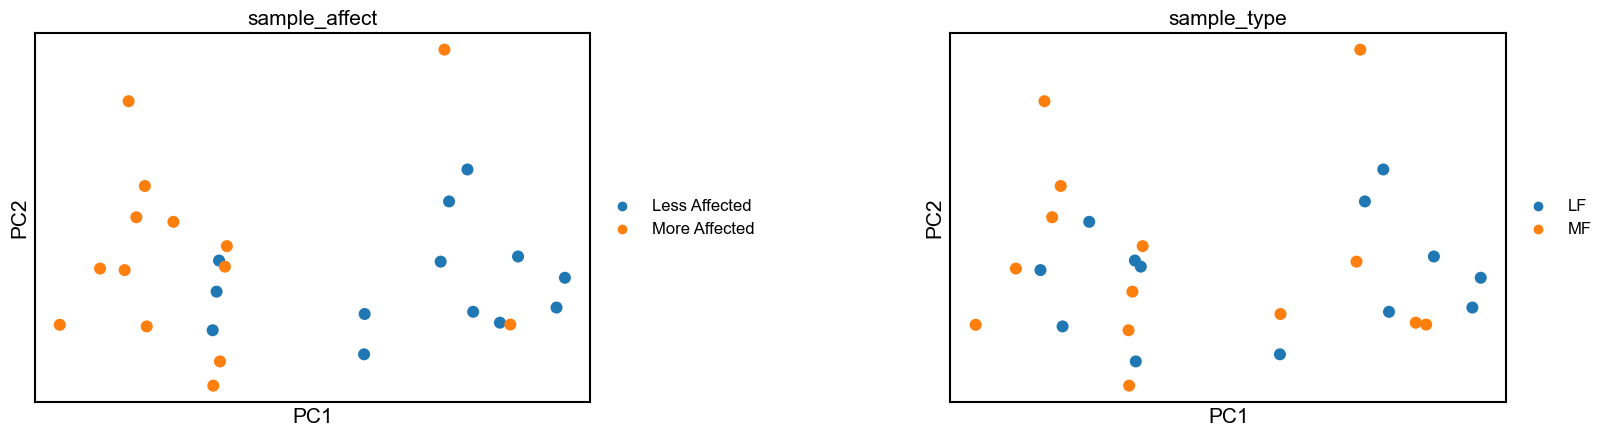

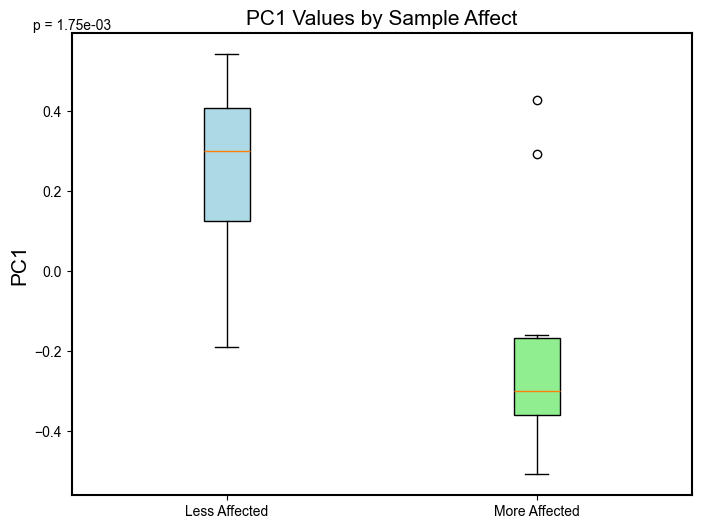


PC1 Separation Metrics:
-----------------------
Less Affected Mean PC1: 0.224
More Affected Mean PC1: -0.208
Absolute difference in means: 0.431

Less Affected PC1 Std: 0.253
More Affected PC1 Std: 0.254

Effect size (Cohen's d): 1.703

PC1 explained variance ratio: 0.821


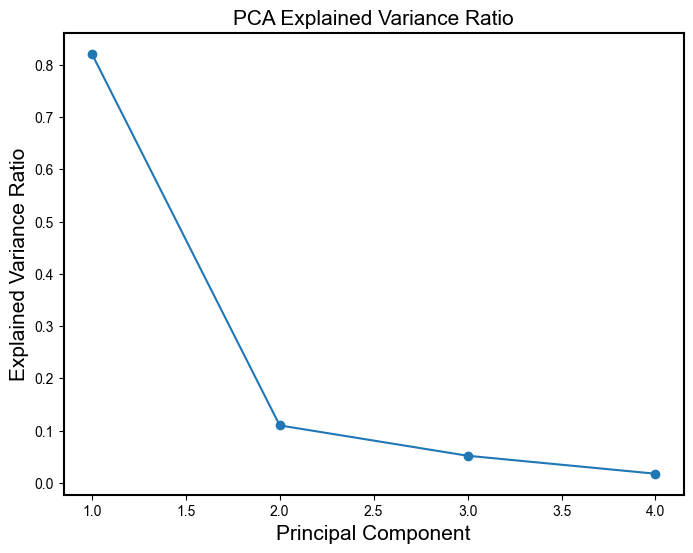

In [5]:
from matplotlib import pyplot as plt

import anndata as ad 


freq_vec, obs = calculate_slice_frequency_vectors(
     res, 
     obs_name='cluster_haruka_salient',
    slice_column='slice_id'
)



patient_adata = ad.AnnData(X=freq_vec.values, obs=obs)
import scanpy as sc 

patient_adata.obs = patient_adata.obs.astype('category')

plt.rcParams['pdf.fonttype'] = 42  
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 15  # Adjust title size
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 'large'

sc.pp.pca(patient_adata) 
sc.tl.pca(patient_adata)
sc.pl.pca(patient_adata, color=['sample_affect', 'sample_type'], s=300, wspace=0.5)

pc1_values = patient_adata.obsm['X_pca'][:, 0]
sample_affects = patient_adata.obs['sample_affect']

# Create figure
plt.figure(figsize=(8, 6))

# Create boxplot
box_plot = plt.boxplot([pc1_values[sample_affects == 'Less Affected'], 
                       pc1_values[sample_affects == 'More Affected']], 
                      labels=['Less Affected', 'More Affected'],
                      patch_artist=True)

colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Perform Mann-Whitney U test
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(pc1_values[sample_affects == 'Less Affected'],
                         pc1_values[sample_affects == 'More Affected'])

# Add p-value annotation
plt.text(0.5, plt.ylim()[1], f'p = {pval:.2e}', 
         horizontalalignment='center',
         verticalalignment='bottom')



# Customize plot
plt.ylabel('PC1')
plt.title('PC1 Values by Sample Affect')

# Save plot

plt.show()

# Calculate metrics for PC1 separation between groups
print("\nPC1 Separation Metrics:")
print("-----------------------")

# Calculate mean PC1 values for each group
less_affected_pc1 = pc1_values[sample_affects == 'Less Affected']
more_affected_pc1 = pc1_values[sample_affects == 'More Affected']

print(f"Less Affected Mean PC1: {less_affected_pc1.mean():.3f}")
print(f"More Affected Mean PC1: {more_affected_pc1.mean():.3f}")
print(f"Absolute difference in means: {abs(less_affected_pc1.mean() - more_affected_pc1.mean()):.3f}")

# Calculate standard deviations
print(f"\nLess Affected PC1 Std: {less_affected_pc1.std():.3f}")
print(f"More Affected PC1 Std: {more_affected_pc1.std():.3f}")

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt((less_affected_pc1.var() + more_affected_pc1.var()) / 2)
cohens_d = abs(less_affected_pc1.mean() - more_affected_pc1.mean()) / pooled_std
print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")

# Calculate explained variance ratio for PC1
explained_var_ratio = patient_adata.uns['pca']['variance_ratio'][0]
print(f"\nPC1 explained variance ratio: {explained_var_ratio:.3f}")
# Perform K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
explained_var_ratio = patient_adata.uns['pca']['variance_ratio']
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio') 
plt.title('PCA Explained Variance Ratio')
plt.grid(False)

plt.show()

